# Online MLP training on a subspace using SMC

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree
from functools import partial
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp
from sklearn.metrics import confusion_matrix

tfd = tfp.distributions

2022-09-06 13:40:20.166945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(linewidth=200, suppress=True)

In [3]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

    
def fz(W):
    return W


def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle = jax.random.split(key, 3)
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    X = jnp.c_[x, y]

    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    X, y = jnp.array(X[shuffled_ixs, :].T)
    return X, y


def generate_train_test_data(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    x, y = sample_observations(key, f, n_obs, xmin, xmax, x_noise, y_noise)
    xtest = jnp.linspace(x.min(), x.max(), n_obs)
    return (x, y), (xtest, f(xtest))

In [4]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_particles_init, key_smc, key_dummy, key_pm = jax.random.split(key, 6)

Text(0.5, 1.0, 'Training data')

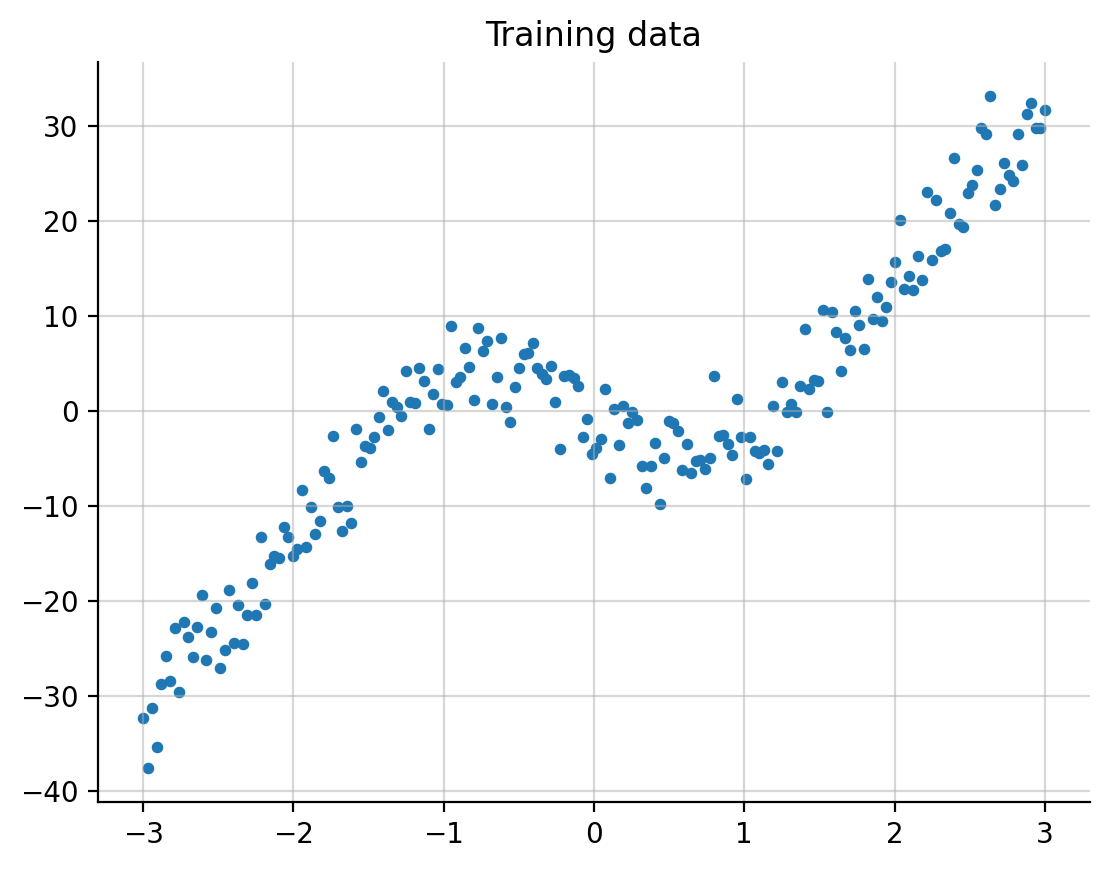

In [5]:
n_obs = 200
xmin, xmax = -3, 3
xnoise, ynoise = 0.0, 3.0
(x, y), (xtest, ytest) = generate_train_test_data(key_sample_obs, f, n_obs,
                                                  xmin, xmax, xnoise, ynoise)
plt.scatter(x, y, s=10)
plt.grid(alpha=0.5)
plt.title("Training data")

## SMC sampling

In [208]:
# Suppose we know the standard deviation of the observations
alpha = 3.0

def smc_step(state, xs, reconstruct_fn, projection_matrix):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=0.1)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    mean_obs = jax.vmap(model.apply, (0, None))(particles_full, xobs[None]).ravel()
    dist_obs = tfd.Normal(loc=mean_obs, scale=alpha)
    
    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [210]:
n_particles = 500
model = MLP(n_hidden=10, n_out=1)
batch = jnp.ones((1, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [211]:
# q(θ{1})
dim_full = len(params_all_flat)
dim_subspace = 10
proj_matrix = jax.random.bernoulli(key_pm, shape=(dim_full, dim_subspace)).astype(float)
particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

In [212]:
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, x, y)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn, projection_matrix=proj_matrix)
(_, particles_final_sub), hist = jax.lax.scan(part_smc_step, init_state, xs)

In [213]:
particles_hist = hist["particles"]
log_weights_hist = hist["log_weights"]

In [215]:
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

f_particles = jax.vmap(model.apply, (0, None))(particles_final, xtest[:, None])[..., 0]
yhat_mean = f_particles.mean(axis=0)
yhat_std = f_particles.std(axis=0)

plt.plot(xtest, yhat_mean)
plt.fill_between(xtest, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="tab:blue", alpha=0.2)
plt.scatter(x, y, s=10, c="tab:orange")
plt.grid(alpha=0.5)

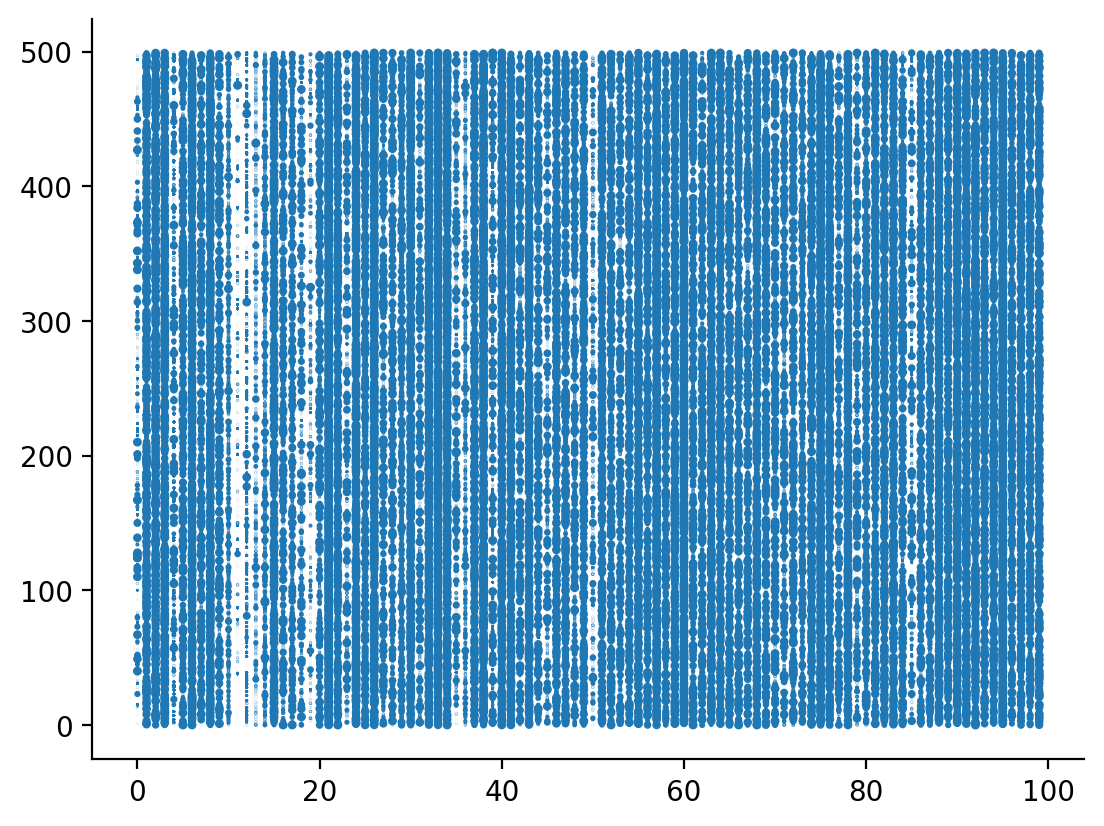

In [216]:
weights = jnp.exp(log_weights_hist - jax.nn.logsumexp(log_weights_hist, axis=1, keepdims=True))
yvals = jnp.arange(n_particles)
for xp, wvec in enumerate(weights[:100]):
    w_rescale = wvec / wvec.max() * 5.0
    plt.scatter(xp * jnp.ones(n_particles), yvals, s=w_rescale, c="tab:blue")
plt.title("Resampled particles")

## Classification (2D)

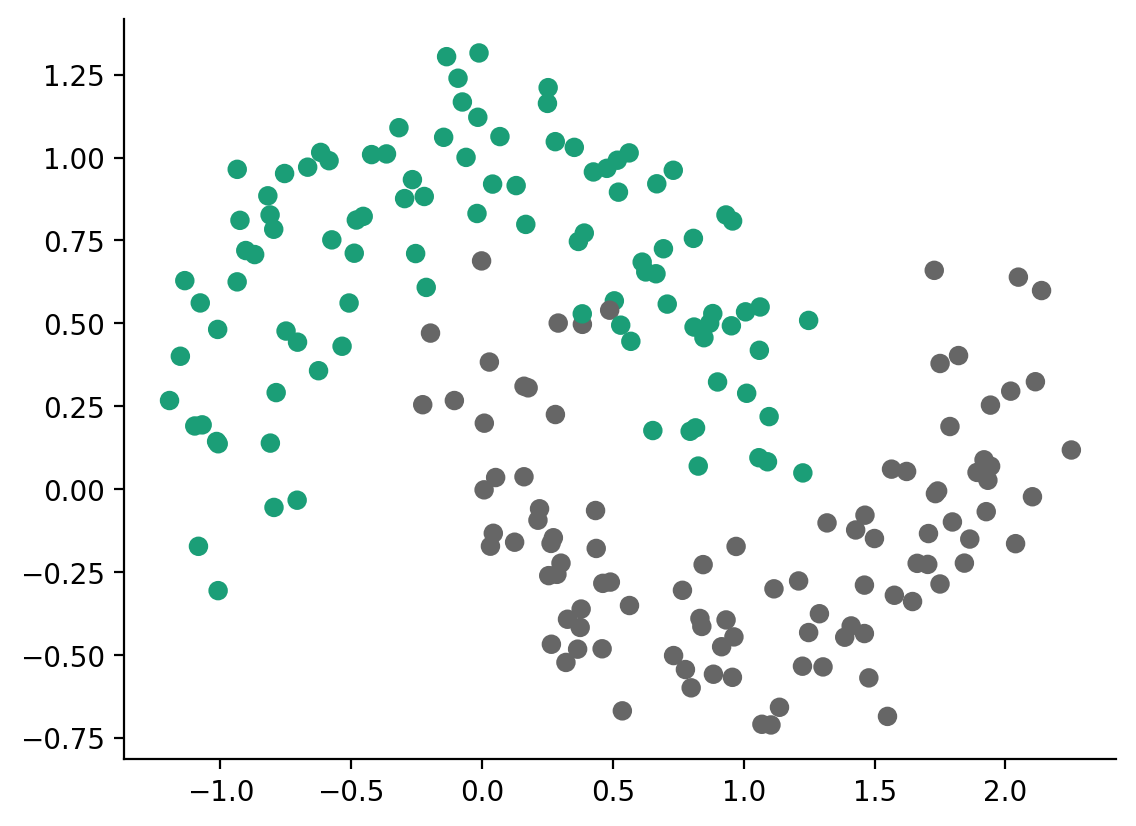

In [419]:
n_obs = 200
X, y = make_moons(n_samples=n_obs, random_state=314, noise=0.15)
y_ohe = jax.nn.one_hot(y, num_classes=2)
plt.scatter(*X.T, c=y, cmap="Dark2")

In [420]:
def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=0.1)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [421]:
n_particles = 500
model = MLP(n_hidden=20, n_out=2)
batch = jnp.ones((1, 2))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [422]:
# q(θ{1})
dim_full = len(params_all_flat)
dim_subspace = 10
proj_matrix = jax.random.bernoulli(key_pm, shape=(dim_full, dim_subspace)).astype(float)
particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

In [423]:
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X, y_ohe)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=2)
(_, particles_final_sub), hist = jax.lax.scan(part_smc_step, init_state, xs)
log_weights_hist = hist["log_weights"]

In [424]:
vmin, vmax = X.min(), X.max()
step = 0.1
grid = jnp.mgrid[vmin:vmax+step:step, vmin:vmax+step:+step]

In [425]:
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

In [426]:
apply_grid = jax.vmap(model.apply, (0, None))
apply_grid = jax.vmap(apply_grid, (None, 1), out_axes=0)
apply_grid = jax.vmap(apply_grid, (None, 2), out_axes=1)

(-1.1939289455734807, 2.2516078435554183)

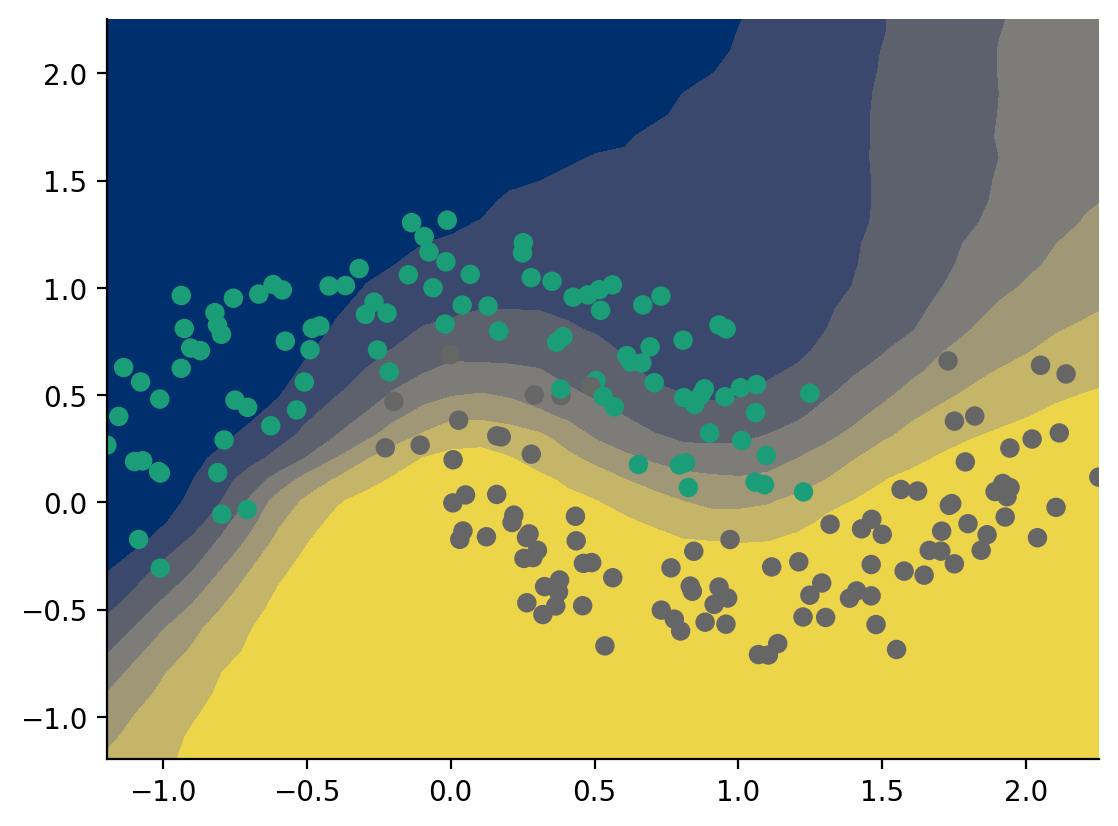

In [427]:
P = apply_grid(particles_final, grid).argmax(axis=-1).mean(axis=-1)
plt.contourf(*grid, P, cmap="cividis")
plt.scatter(*X.T, c=y, cmap="Dark2")
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)

Text(0.5, 1.0, 'Resampled particles')

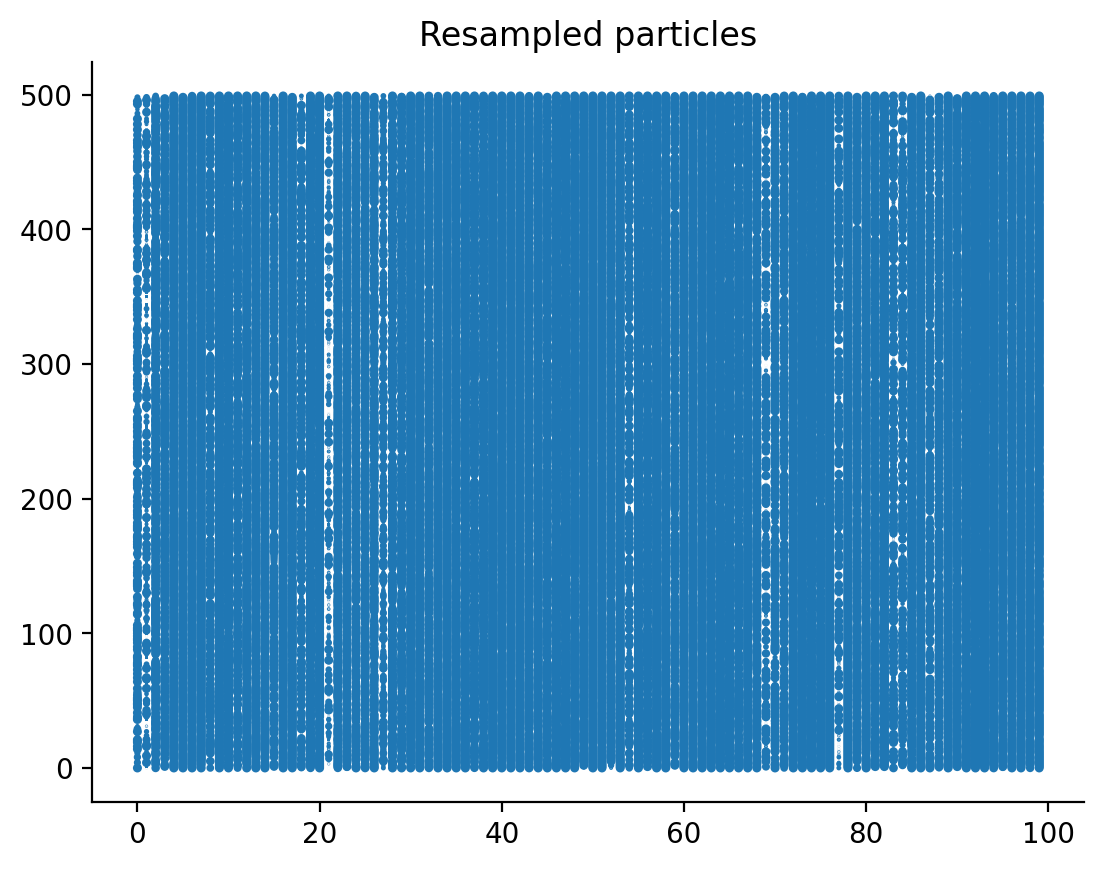

In [428]:
weights = jnp.exp(log_weights_hist - jax.nn.logsumexp(log_weights_hist, axis=1, keepdims=True))
yvals = jnp.arange(n_particles)
for xp, wvec in enumerate(weights[:100]):
    w_rescale = wvec / wvec.max() * 5.0
    plt.scatter(xp * jnp.ones(n_particles), yvals, s=w_rescale, c="tab:blue")
plt.title("Resampled particles")

## Classification ($28^2$)

In [6]:
from torchvision.datasets import MNIST

In [7]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [8]:
class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = self.activation(x)
        x = nn.Dense(features=84)(x)
        x = self.activation(x)
        x = nn.Dense(features=self.num_classes)(x)
        x = nn.log_softmax(x)
        return x


def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=0.1)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [9]:
n_obs = 1000
X_train = jnp.array(mnist_train.data)[:n_obs]
y_train = jnp.array(mnist_train.targets)[:n_obs]

num_train, *_ = X_train.shape
# "Gaussanised" MNIST
X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, 10)
num_samples = len(X_train)

In [10]:
model = SmallCNN(10)
batch = jnp.ones((1, 28, 28, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [11]:
dim_full = len(params_all_flat)
n_particles = 500
dim_subspace = 1000
proj_matrix = jax.random.bernoulli(key_pm, p=0.5, shape=(dim_full, dim_subspace)).astype(float)
particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

proj_matrix.shape

(152410, 1000)

In [12]:
%%time
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train, y_ohe_train)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=10)
(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))
log_weights_hist = hist["log_weights"]

CPU times: user 12.6 s, sys: 22.2 ms, total: 12.6 s
Wall time: 21.6 s


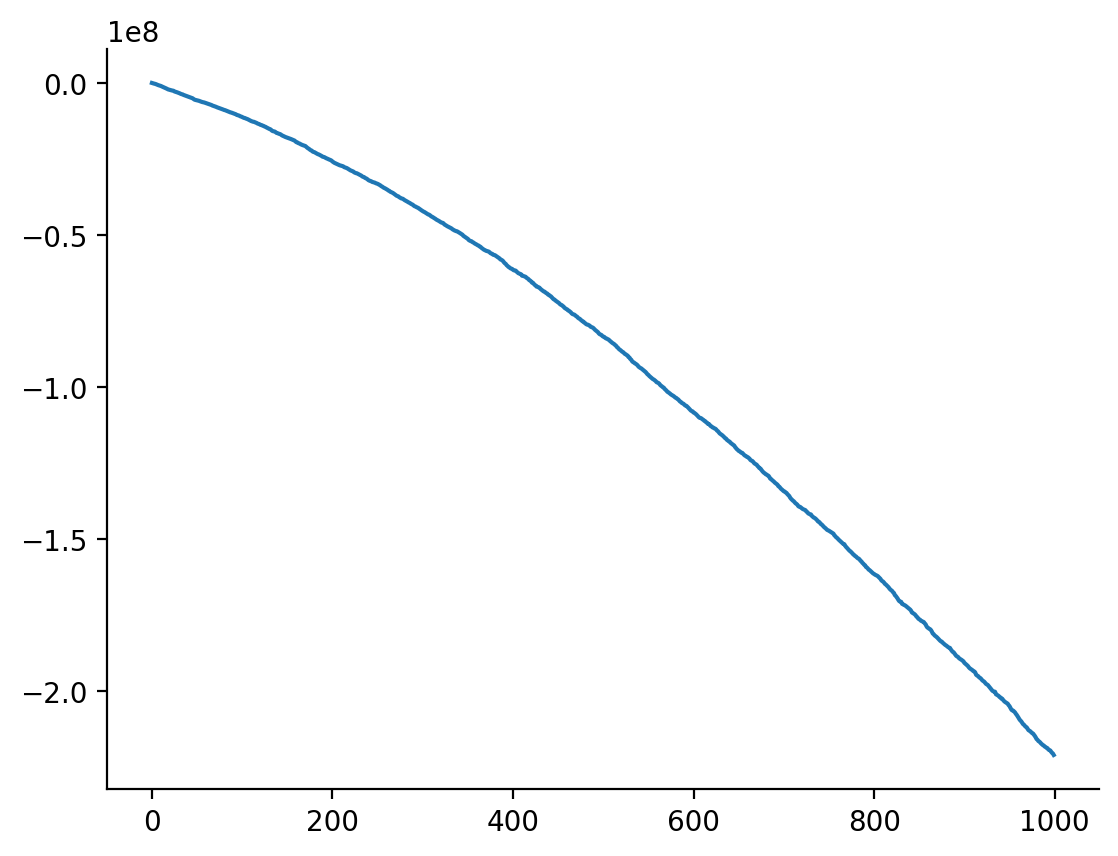

In [13]:
plt.plot(log_weights_hist.sum(axis=-1).cumsum())

Text(0.5, 1.0, 'Resampled particles')

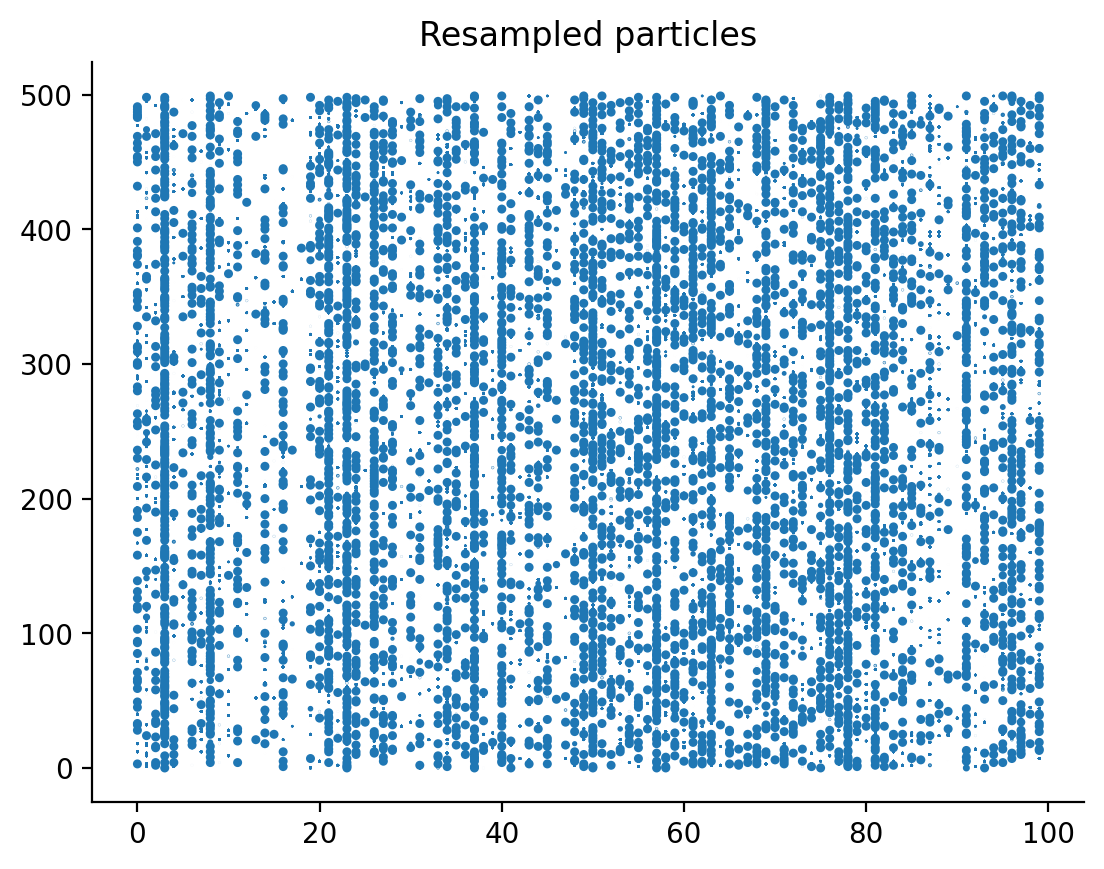

In [14]:
weights = jnp.exp(log_weights_hist - jax.nn.logsumexp(log_weights_hist, axis=1, keepdims=True))
yvals = jnp.arange(n_particles)
for xp, wvec in enumerate(weights[:100]):
    w_rescale = wvec / wvec.max() * 5.0
    plt.scatter(xp * jnp.ones(n_particles), yvals, s=w_rescale, c="tab:blue")
plt.title("Resampled particles")

In [15]:
%%time 
device_cpu, *_ = jax.devices("cpu")
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train[:100])
yhat_train = jax.nn.softmax(yhat_train)

CPU times: user 8.33 s, sys: 9.8 s, total: 18.1 s
Wall time: 3.45 s


In [16]:
yhat_train.mean(axis=0)[:20]

DeviceArray([[0.05555782, 0.11573999, 0.05200809, 0.36687195, 0.03425167, 0.04790856, 0.03600863, 0.0634878 , 0.21659972, 0.01156576],
             [0.008     , 0.16935605, 0.02366394, 0.22006306, 0.01833601, 0.0767844 , 0.024     , 0.004     , 0.35195997, 0.10383663],
             [0.05670362, 0.012     , 0.01400048, 0.7361518 , 0.08799725, 0.        , 0.014     , 0.00200086, 0.0411489 , 0.03599706],
             [0.00000001, 0.004     , 0.0479748 , 0.7477606 , 0.02817159, 0.01      , 0.        , 0.02382834, 0.13826475, 0.        ],
             [0.        , 0.004     , 0.002     , 0.68871397, 0.15013295, 0.06598332, 0.006     , 0.00199608, 0.07717373, 0.004     ],
             [0.03000001, 0.00413432, 0.0979998 , 0.49989104, 0.04402288, 0.11445575, 0.04601536, 0.01800087, 0.13947979, 0.00600012],
             [0.        , 0.04200331, 0.        , 0.4309966 , 0.01397169, 0.05746133, 0.07368169, 0.01201556, 0.36586988, 0.004     ],
             [0.07181407, 0.07006541, 0.09599956, 0.440

In [17]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=1)
confusion_matrix(y_train[:100], yhat_train_argmax)

array([[ 0,  0,  0,  9,  0,  3,  0,  0,  1,  0],
       [ 0,  0,  0, 13,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0]])

In [18]:
y_train[:10]

DeviceArray([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

In [19]:
yhat_train_argmax[:10]

DeviceArray([3, 8, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

## Initial setup

In [60]:
%%time 
device_cpu, *_ = jax.devices("cpu")
particles_final = jnp.einsum("pk,mk->pm", particles_init, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train[:100])
yhat_train = jax.nn.softmax(yhat_train)

yhat_train.mean(axis=0)[:10]

CPU times: user 7.48 s, sys: 1.64 s, total: 9.12 s
Wall time: 1.1 s


DeviceArray([[0.09145603, 0.08895882, 0.07312053, 0.08420653, 0.11718529, 0.12138329, 0.12616105, 0.08692642, 0.08390163, 0.12670042],
             [0.09548666, 0.09158087, 0.07336824, 0.0861362 , 0.11918797, 0.1153836 , 0.11871609, 0.09281646, 0.08259957, 0.12472437],
             [0.0868571 , 0.09783804, 0.07063646, 0.09094405, 0.1148972 , 0.11930436, 0.12387307, 0.09292511, 0.08200503, 0.12071963],
             [0.09062673, 0.08479441, 0.07641649, 0.08995748, 0.11488482, 0.13123834, 0.12010422, 0.08878773, 0.07852382, 0.12466599],
             [0.09685711, 0.09583805, 0.07063646, 0.08894405, 0.11089721, 0.11730435, 0.12387307, 0.0909251 , 0.08800503, 0.11671963],
             [0.09153411, 0.09383927, 0.07516409, 0.08496504, 0.117186  , 0.11542978, 0.11817913, 0.08892725, 0.08804269, 0.12673268],
             [0.09685031, 0.0878319 , 0.08047932, 0.09294108, 0.11088564, 0.11529571, 0.12612584, 0.08692385, 0.08196791, 0.12069849],
             [0.09509625, 0.0936807 , 0.07280118, 0.090

In [61]:
yhat_train.mean(axis=0)[:10].argmax(axis=1)

DeviceArray([9, 9, 6, 5, 6, 9, 6, 6, 6, 4], dtype=int32)